## Load necessary libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import PIL
plt.style.use('fivethirtyeight')

## Load dataset from local image files

Also verify dataset was succesfully downloaded

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(370, 320))

Found 680 files belonging to 2 classes.


In [4]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(370, 320))

Found 120 files belonging to 2 classes.


In [5]:
class_names = train_ds.class_names
print(train_ds.class_names)

['adults', 'children']


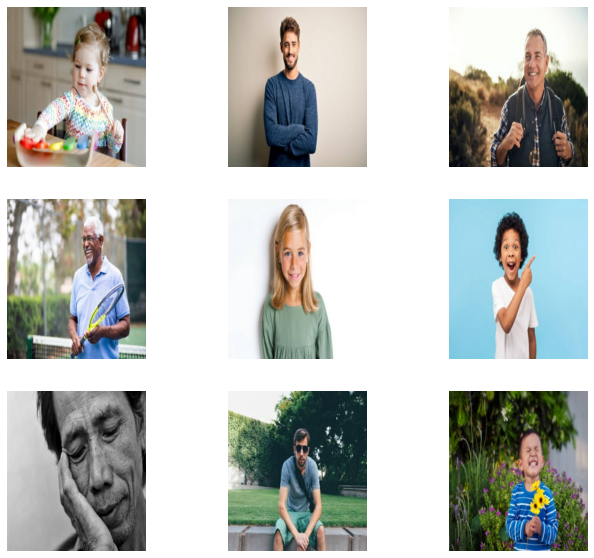

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure dataset to increase performance

Use dataset.cache - keeps images after they are loaded off disk during first epoch. Helps prevent dataset from bottlenecking on local disk.
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache

Use dataset.prefetch - overlaps data preprocessing and model execution while training.
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# normalization_layer = layers.Rescaling(1./255)

# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_train_ds))
# first_training_image = image_batch[0]

# normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_test_ds))
# first_test_image = image_batch[0]

# print(first_training_image)

## Create the model

Also standardizing data with layers.Rescaling function in order to ensure values are in the range of [0, 1].

In [9]:
img_height = 370
img_width=320

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and summarize model properties

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 370, 320, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 370, 320, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 185, 160, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 185, 160, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 92, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 80, 64)        1

## Train the model

In [12]:
# epochs=10

# history = model.fit(
#   train_ds,
#   validation_data=test_ds,
#   epochs=epochs
# )

## Visualize the model accuracy and loss

In [13]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(10, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

## Model exhibits properties of overfitting

Distinct differences in training and Validation accuracy indicate a need to alter model to compensate for overfitting.

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

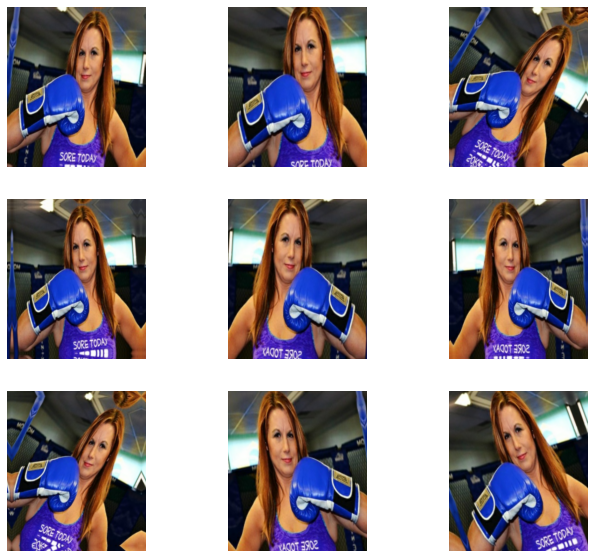

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/15
22/22 [==============================] - 33s 1s/step - loss: 1.6597 - accuracy: 0.5103 - val_loss: 0.6564 - val_accuracy: 0.5083
Epoch 2/15
22/22 [==============================] - 28s 1s/step - loss: 0.6869 - accuracy: 0.5588 - val_loss: 0.6534 - val_accuracy: 0.5917
Epoch 3/15
22/22 [==============================] - 29s 1s/step - loss: 0.6995 - accuracy: 0.5441 - val_loss: 0.6356 - val_accuracy: 0.6417
Epoch 4/15
22/22 [==============================] - 28s 1s/step - loss: 0.6630 - accuracy: 0.5853 - val_loss: 0.6316 - val_accuracy: 0.6333
Epoch 5/15
22/22 [==============================] - 28s 1s/step - loss: 0.6455 - accuracy: 0.5926 - val_loss: 0.6022 - val_accuracy: 0.6833
Epoch 6/15
22/22 [==============================] - 28s 1s/step - loss: 0.6293 - accuracy: 0.6485 - val_loss: 0.6058 - val_accuracy: 0.6583
Epoch 7/15
22/22 [==============================] - 28s 1s/step - loss: 0.6123 - accuracy: 0.6647 - val_loss: 0.6203 - val_accuracy: 0.6250
Epoch 8/15
22/22 [==

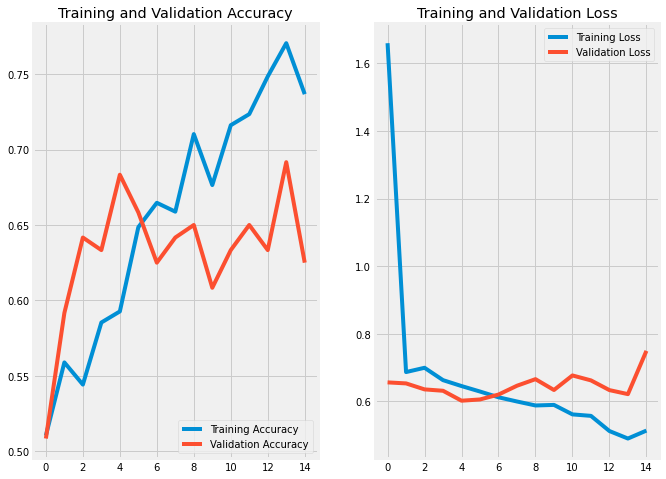

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test the model on an image not included in original dataset

In [20]:
adult_url = "https://media.istockphoto.com/photos/mature-student-using-digital-tablet-in-adult-education-class-picture-id876965270?k=20&m=876965270&s=612x612&w=0&h=B64KzJ-F9sBPPI0rxBbbVU3_GAwOk972xVlzkobwtkk="
adult_path = tf.keras.utils.get_file('stock_adult', origin=adult_url)

img = tf.keras.utils.load_img(
    adult_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 124ms/step
This image most likely belongs to adults with a 91.76 percent confidence.
